In [11]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [12]:
mpg_raw_data = pd.read_table("autompg/auto-mpg.data", header=None, sep="\s+")
mpg_raw_data.columns = [
    "mpg",
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model year",
    "origin",
    "car name",
]
mpg_raw_data = mpg_raw_data.drop(columns=["car name"]).dropna()
mpg_raw_data = mpg_raw_data[~mpg_raw_data.isin(["?"]).any(axis=1)]
mpg_filtered_data = mpg_raw_data.apply(pd.to_numeric, errors="coerce").dropna()

mpg_mean = mpg_filtered_data["mpg"].mean()
mpg_std = mpg_filtered_data["mpg"].std()

mpg_normalized = (
    mpg_filtered_data - mpg_filtered_data.mean()
) / mpg_filtered_data.std()

train_mpg, test_mpg = train_test_split(mpg_normalized, test_size=0.2, random_state=42)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\romrellb\AppData\Local\Temp\ipykernel_19892\67010936.py:1: SyntaxWarning: invalid escape sequence '\s'
  mpg_raw_data = pd.read_table("autompg/auto-mpg.data", header=None, sep="\s+")


In [13]:
class NNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim: list, output_dim):
        super(NNModel, self).__init__()
        self.activation = torch.nn.LeakyReLU()
        self.layers = []
        hidden_dim.insert(0, input_dim)
        for i in range(len(hidden_dim) - 1):
            self.layers.append(torch.nn.Linear(hidden_dim[i], hidden_dim[i + 1]))
        self.out = torch.nn.Linear(hidden_dim[-1], output_dim)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        x = self.out(x)
        return x

In [14]:
class MPGDataset(Dataset):
    def __init__(self, df, feature_cols, label_col):
        super().__init__()
        self.dataframe = df
        self.features = df[feature_cols].values
        self.labels = df[label_col].values.reshape(-1, 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(
            self.labels[idx], dtype=torch.float32
        )


feature_cols = [
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model year",
    "origin",
]
label_col = "mpg"
BatchSize = 3
train_dataset = MPGDataset(train_mpg, feature_cols, label_col)
train_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True)
test_dataset = MPGDataset(test_mpg, feature_cols, label_col)
test_loader = DataLoader(test_dataset, batch_size=BatchSize, shuffle=False)

In [ ]:
model = NNModel(len(feature_cols), [128, 64], 1)

Epochs = 40
LossFunction = torch.nn.MSELoss()
Optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses = []
test_losses = []
abs_test_losses = []

for epoch in range(Epochs):
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False) as t:
        for features, labels in t:
            Optimizer.zero_grad()
            predictions = model(features)
            loss = LossFunction(predictions, labels)
            loss.backward()
            Optimizer.step()
            epoch_loss += loss.item()
            t.set_postfix(loss=loss.item())
    train_losses.append(epoch_loss / len(train_loader))
    with tqdm(test_loader, desc=f"Epoch {epoch + 1} Test", leave=False) as t:
        epoch_loss = 0
        abs_loss = 0
        for features, labels in t:
            predictions = model(features)
            loss = LossFunction(predictions, labels)
            abs_loss += torch.abs(predictions - labels).mean().item()
            epoch_loss += loss.item()
            t.set_postfix(loss=loss.item())
        test_losses.append(epoch_loss / len(test_loader))
        abs_test_losses.append(abs_loss / len(test_loader))

scatter_data = []
for features, labels in test_loader:
    predicted = model(features)
    labels = labels.numpy()
    for x, y in zip(predicted, labels):
        scatter_data.append((x.item(), y.item()))
scatter_data = np.array(scatter_data)
scatter_data = scatter_data * mpg_std + mpg_mean

Epoch 1:   0%|          | 0/105 [00:00<?, ?it/s, loss=1.66] 

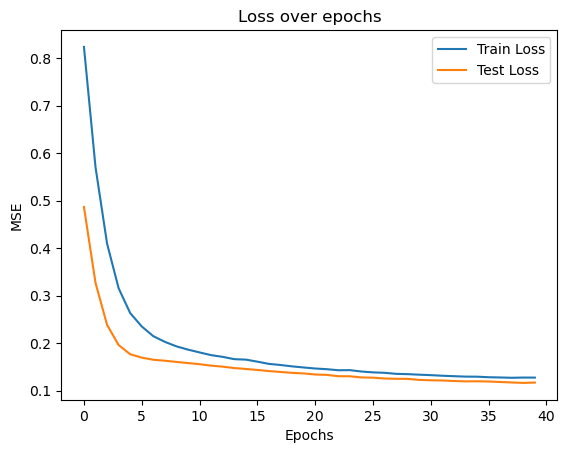

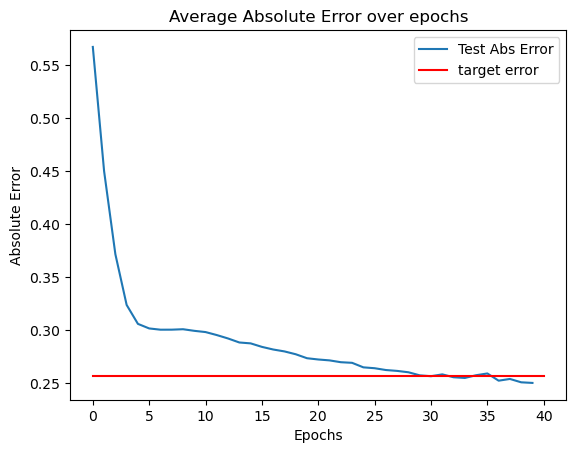

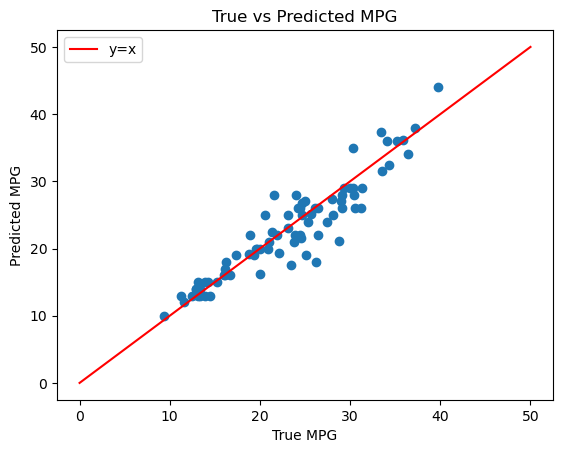

Final absolute error:  0.24990572256070595
final Absolute error in original scale:  1.9505160355234448


In [ ]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss over epochs")
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.show()
plt.figure()
plt.plot(abs_test_losses, label="Test Abs Error")
plt.plot([0, Epochs], [2 / mpg_std, 2 / mpg_std], color="red", label="target error")
plt.legend()
plt.title("Average Absolute Error over epochs")
plt.ylabel("Absolute Error")
plt.xlabel("Epochs")
plt.show()
plt.figure()
plt.scatter(*zip(*scatter_data))
plt.xlabel("True MPG")
plt.ylabel("Predicted MPG")
plt.plot([0, 50], [0, 50], color="red", label="y=x")
plt.title("True vs Predicted MPG")
plt.legend()
plt.show()

print("Final absolute error: ", abs_test_losses[-1])
print("final Absolute error in original scale: ", abs_test_losses[-1] * mpg_std)